In [1]:
#Cargar las librerias necesarias

import pandas as pd # Manejo y análisis de estructuras de datos
import numpy as np # Cálculo numérico y el análisis de datos
import seaborn as sns # Creación gráficos estadísticos
import matplotlib.pyplot as plt # Creación de gráficos en dos dimensiones
import plotly.graph_objs as go # Creación de gráficos en tres dimensiones
import plotly.express as px # Creación de gráficos en tres dimensiones


# librerías de para implementar modelo Kmeans
from sklearn.cluster import AgglomerativeClustering #algoritmos de agrupamiento o clustering, dividir datos en grupos o clusters basados en su similitud.
from sklearn.preprocessing import StandardScaler #escalar o normalizar los datos 
from scipy.cluster.hierarchy import linkage, dendrogram #herramientas para realizar agrupamiento jerárquico y visualización de dendrogramas.
#dendrogram:  genera un gráfico de árbol 

# librerías de para evaluar el modelo
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from datetime import datetime

#Librería para evitar la advertencia de que el modelo tiene una pérdida de memoria en Windows 
import warnings
warnings.filterwarnings('ignore')

### 1). Realizar un análisis exploratorio de los datos para identificar relaciones entre variables, valores atípicos, tendencias, etc.

In [5]:
# Cargar el conjunto de datos en la variable data
data = pd.read_csv('Mall_Customers.csv')

In [7]:
data.head(20)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
5,6,Female,22,17,76
6,7,Female,35,18,6
7,8,Female,23,18,94
8,9,Male,64,19,3
9,10,Female,30,19,72


In [9]:
data.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [14]:
# Obtener información sobre el tipo de datos y el total de valores en cada columna
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
None


Text(0.5, 1.0, 'Identificación de Datos Faltantes y Atípicos')

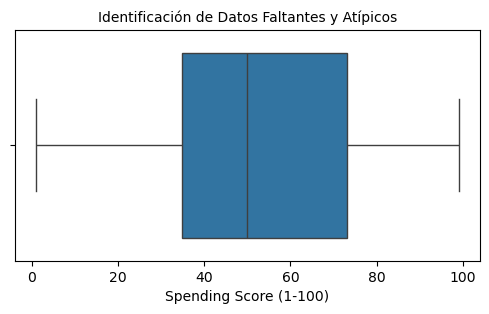

In [20]:
#Identificación de Datos Faltantes y Atípicos
plt.figure(figsize=(6, 3))
sns.boxplot(x=data['Spending Score (1-100)'])
plt.title('Identificación de Datos Faltantes y Atípicos',fontsize=10)

### 2). Preprocesar los datos limpiándolos, tratando valores faltantes y transformándolos según sea necesario.

In [23]:
# Identificar columnas con datos faltantes
print(data.isnull().sum())

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64


Text(0.5, 1.0, 'Identificación de Datos Atípicos')

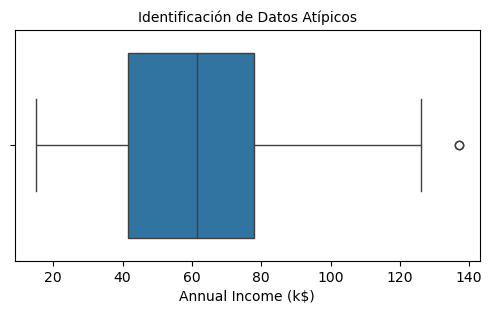

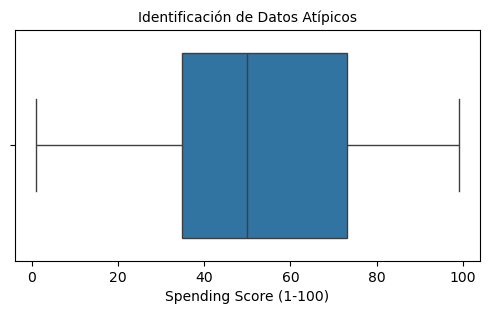

In [27]:
#Identificación de Datos Atípicos

plt.figure(figsize=(6, 3))
sns.boxplot(x=data['Annual Income (k$)'])
plt.title('Identificación de Datos Atípicos',fontsize=10)

#Identificación de Datos Atípicos

plt.figure(figsize=(6, 3))
sns.boxplot(x=data['Spending Score (1-100)'])
plt.title('Identificación de Datos Atípicos',fontsize=10)

In [29]:
#Conteo de Datos Atípicos

nivel_minimo=0
nivel_maximo=100
Total_Atipicos=((data['Spending Score (1-100)']<nivel_minimo)|(data['Spending Score (1-100)']>nivel_maximo)).sum()
print("El total de datos atípicos es {}".format(Total_Atipicos))

Total_Atipicos=((data['Annual Income (k$)']<nivel_minimo)|(data['Annual Income (k$)']>nivel_maximo)).sum()
print("El total de datos atípicos es {}".format(Total_Atipicos))

El total de datos atípicos es 0
El total de datos atípicos es 14


In [31]:
# Filtra Datos Atípicos

Datos=data[(data['Spending Score (1-100)']<nivel_maximo)&(data['Spending Score (1-100)']>nivel_minimo)]
Datos=data[(data['Annual Income (k$)']<nivel_maximo)&(data['Annual Income (k$)']>nivel_minimo)]

In [33]:
#Revisión del tipo de datos y datos faltantes

Datos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 186 entries, 0 to 185
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              186 non-null    int64 
 1   Gender                  186 non-null    object
 2   Age                     186 non-null    int64 
 3   Annual Income (k$)      186 non-null    int64 
 4   Spending Score (1-100)  186 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 8.7+ KB


### 3). Seleccionar las características más relevantes para entrenar el modelo utilizando selección de características.

In [48]:
# Calcular el año actual
current_year = datetime.now().year

# Calcular la edad y agregar como columna 'Age'
Datos['edad'] = current_year - Datos['Age']

# Mostrar las primeras filas para verificar
Datos[['Age','edad']].head()

,Age,edad
0,19,2005
1,21,2003
2,20,2004
3,23,2001
4,31,1993


In [62]:
# Filtrar columnas del modelo 
Datos1 = Datos[["Age","Spending Score (1-100)"]]

# Revisión de los datos de las variables objetivo
Datos1.head(40)

,Age,Spending Score (1-100)
0,19,39
1,21,81
2,20,6
3,23,77
4,31,40
5,22,76
6,35,6
7,23,94
8,64,3
9,30,72


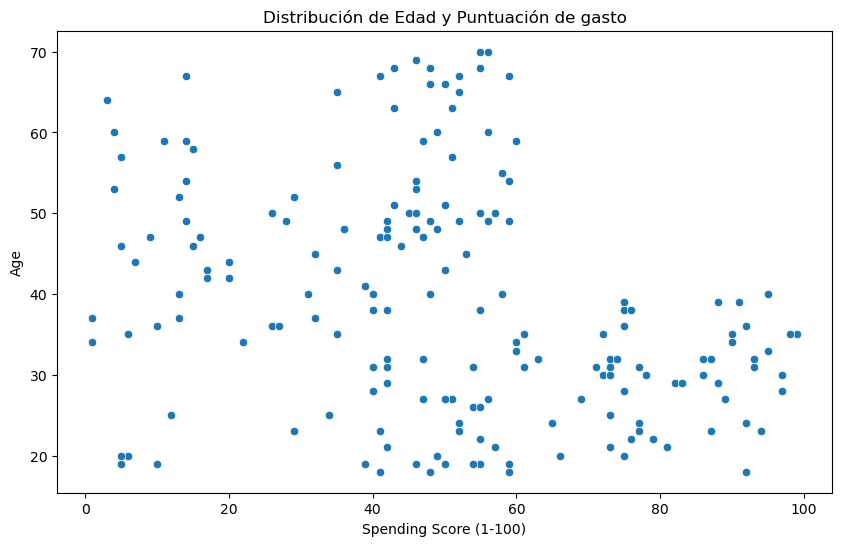

In [64]:
# Grafica antes del agrupamiento

plt.figure(figsize=(10, 6))
sns.scatterplot(x=Datos1['Spending Score (1-100)'], y=Datos1['Age'])
plt.title('Distribución de Edad y Puntuación de gasto')
plt.xlabel('Spending Score (1-100)')
plt.ylabel('Age')
plt.show()

### 4). Entrenar el modelo configurando los diferentes hiperparámetros.

In [69]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(Datos[['Spending Score (1-100)','Age']])

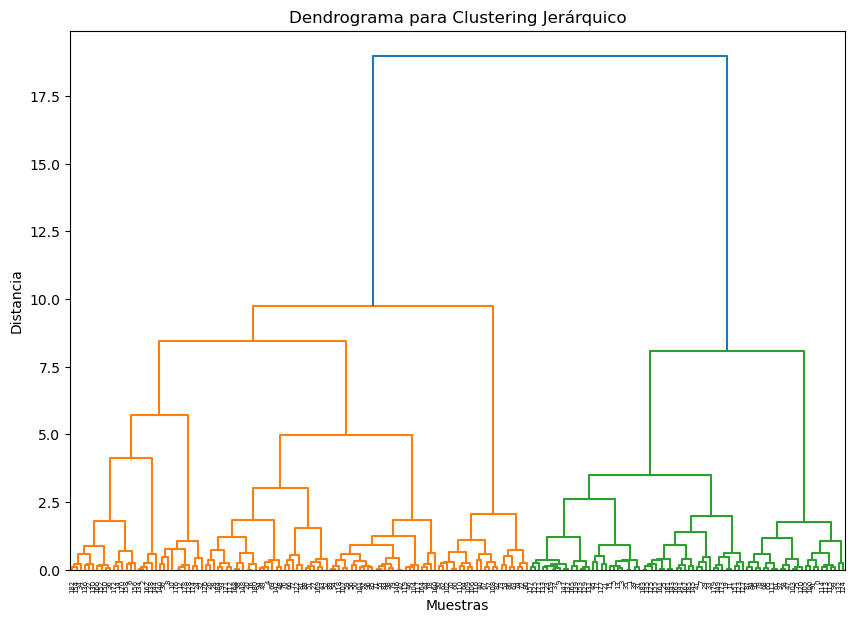

In [71]:
# Check for and handle non-finite values in scaled_data
scaled_data = np.nan_to_num(scaled_data)  # Reemplaza valores NaN, inf y -inf con valores finitos

# Continue with hierarchical clustering
linked = linkage(scaled_data, method='ward') # Realiza el enlace jerárquico con el método de Ward

plt.figure(figsize=(10, 7))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=False) # Dibuja el dendrograma
plt.title('Dendrograma para Clustering Jerárquico')
plt.xlabel('Muestras')
plt.ylabel('Distancia')
plt.show()

### 5). Evaluar el desempeño del modelo con métricas como Coeficiente de Silhouette, Índice de Calinski-Harabasz, etc.

In [73]:
# Assuming 'Datos' is your DataFrame
# Replace NaNs with the mean of each column
Datos[['Spending Score (1-100)', 'Age']] = Datos[['Spending Score (1-100)', 'Age']].fillna(Datos[['Spending Score (1-100)', 'Age']].mean())

# Preprocesamiento de los datos
scaler = StandardScaler()
scaled_data = scaler.fit_transform(Datos[['Spending Score (1-100)', 'Age']])  

# Entrenamiento del modelo de Clustering Jerárquico
model = AgglomerativeClustering(n_clusters=3, linkage='ward')  
labels = model.fit_predict(scaled_data)

# Evaluación del modelo

# Coeficiente de Silhouette
sil_score = silhouette_score(scaled_data, labels)
print(f"Coeficiente de Silhouette: {sil_score}")

# Índice de Calinski-Harabasz
ch_score = calinski_harabasz_score(scaled_data, labels)
print(f"Índice de Calinski-Harabasz: {ch_score}")

# Índice de Davies-Bouldin
db_score = davies_bouldin_score(scaled_data, labels)
print(f"Índice de Davies-Bouldin: {db_score}")

Coeficiente de Silhouette: 0.36516341177134265
Índice de Calinski-Harabasz: 143.48838341697893
Índice de Davies-Bouldin: 0.8375526107405249


### 6). Realizar las diferentes gráficas que permitan visualizar los resultados del modelo

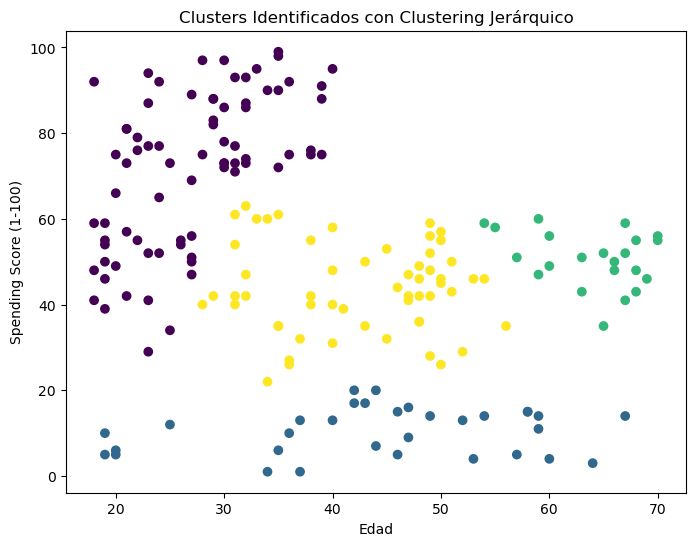

In [77]:
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt

# Aplicar el modelo de clustering jerárquico
model = AgglomerativeClustering(n_clusters=4)  # Ajustar el número de clusters
Datos1['Cluster'] = model.fit_predict(scaled_data)
# Graficar los clusters
plt.figure(figsize=(8, 6))
plt.scatter(Datos['Age'], Datos['Spending Score (1-100)'], c=Datos1['Cluster'], cmap='viridis')
plt.title('Clusters Identificados con Clustering Jerárquico')
plt.xlabel('Edad')
plt.ylabel('Spending Score (1-100)')
plt.show()

Silhouette Score: 0.3706638639714173


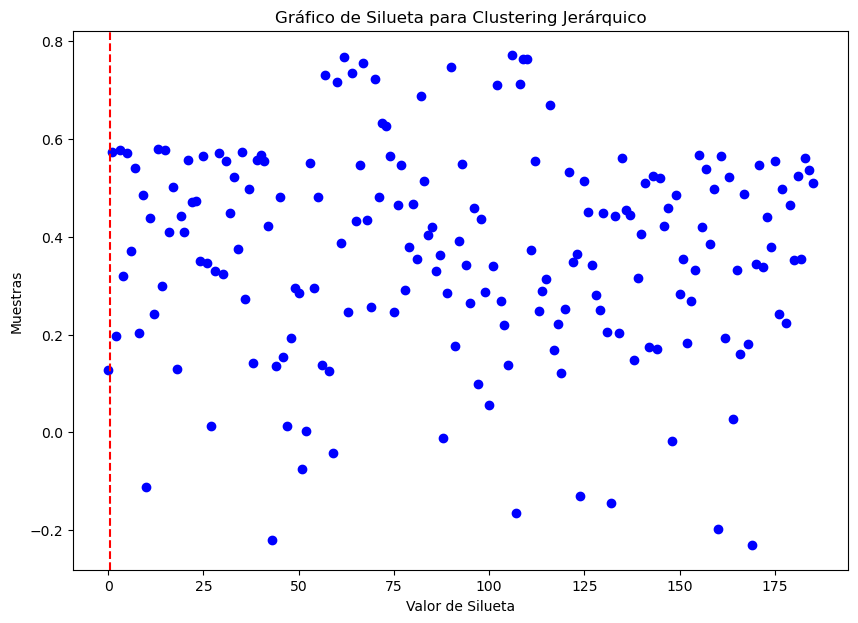

In [79]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt

# Calcular la silueta
silhouette_avg = silhouette_score(scaled_data, model.labels_)
print(f'Silhouette Score: {silhouette_avg}')

# Mostrar el gráfico de silueta
sample_silhouette_values = silhouette_samples(scaled_data, model.labels_)
fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(sample_silhouette_values, 'bo')
ax.axvline(x=silhouette_avg, color="red", linestyle="--")
ax.set_title("Gráfico de Silueta para Clustering Jerárquico")
ax.set_xlabel("Valor de Silueta")
ax.set_ylabel("Muestras")
plt.show()